# Classifying Coronal Origin
Xu and Borovsky (2015) showed that the solar wind can generally be classified into four major types:

| Solar Wind Type | Acronym |
|-----------------|---------|
| Coronal-Hole-Origin Plasma | CHOP |
| Streamer Belt Plasma | SBP |
| Sector-Reversal-Region Plasma | SRRP |
| Ejecta | EJECT |


Zhao et al (2017) 
Different solar wind types exhibit unique in situ properties such as proton speed, ion charge states, and elemental composition, which reflect the characteristics of their source regions in the corona.

- **Active Region (AR) Wind**: Solar wind originating from active regions characterized by higher energy and magnetic activity.
- **AR-Boundary Wind**: Wind that emanates from the boundaries of active regions, which often exhibit transitional properties between active and quieter solar areas.
- **Quiet Sun (QS) Wind**: Wind originating from areas of the Sun with lower magnetic activity, typically quieter and less variable than those from active regions.
- **Coronal Hole (CH) Wind**: Emanates from coronal holes, which are regions on the Sun's surface with open magnetic fields and lower density and temperature, often associated with fast solar wind streams.
- **CH-Boundary Wind**: Wind from the edges of coronal holes, where the solar wind properties may be influenced by interactions between the open magnetic fields of the coronal holes and the surrounding field structures.
- **Helmet-Streamer Associated Wind**: Solar wind associated with helmet streamers, which are large, bright loops of plasma that extend outward from the Sun's surface, often found at the top of closed magnetic loops near active regions. Helmet streamers are typically associated with slow solar wind.

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.decomposition import PCA, KernelPCA
import warnings

# Ignore all Python warnings
warnings.filterwarnings("ignore")

## User Defined Functions

In [5]:
def classify_ch_origin(log10_o7o6, proton_speed):
    if log10_o7o6 <= 0.145:
        return "CH"
    elif log10_o7o6 < 0.145 and log10_o7o6 < 6.008 * math.exp(
        -0.00578 * (10 ** proton_speed) # proton_speed is in log10, transform back
    ):
        return "NCH"
    else:
        return "TR"

## Preprocessed Data Inspection

In [18]:
df = pd.read_csv("../data/ace/preprocessed/insitu_ace_log_scaled.csv")

df["classification"] = df.apply(
    lambda row: classify_ch_origin(row["proton_speed"], row["O7to6"]), axis=1
)
X = df[df.columns[1:-1]] # remove the first (time) and last (classification) columns
print(df.shape)
X.describe()

(72018, 9)


,proton_speed,proton_density,proton_temp,O7to6,C6to5,FetoO,avqFe
count,72018.000000,72018.000000,72018.000000,72018.000000,72018.000000,72018.000000,72018.000000
mean,0.260557,0.056555,0.085341,0.020603,0.017392,0.073226,0.262883
std,0.133627,0.048583,0.065678,0.027141,0.015979,0.044031,0.095902
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.159111,0.028339,0.038878,0.005753,0.007756,0.043972,0.203281
50%,0.227591,0.043280,0.068112,0.012573,0.014121,0.061681,0.243756
75%,0.339707,0.067320,0.112966,0.025495,0.022907,0.088471,0.296336
max,1.000000,1.000000,0.975987,1.000000,1.000000,1.000000,1.000000


In [22]:
print(df["classification"].value_counts())
df["classification"] = df["classification"].astype("category")
df["classification"].cat.codes.value_counts()

TR    57893
CH    14125
Name: classification, dtype: int64


1    57893
0    14125
dtype: int64

### Visualizations

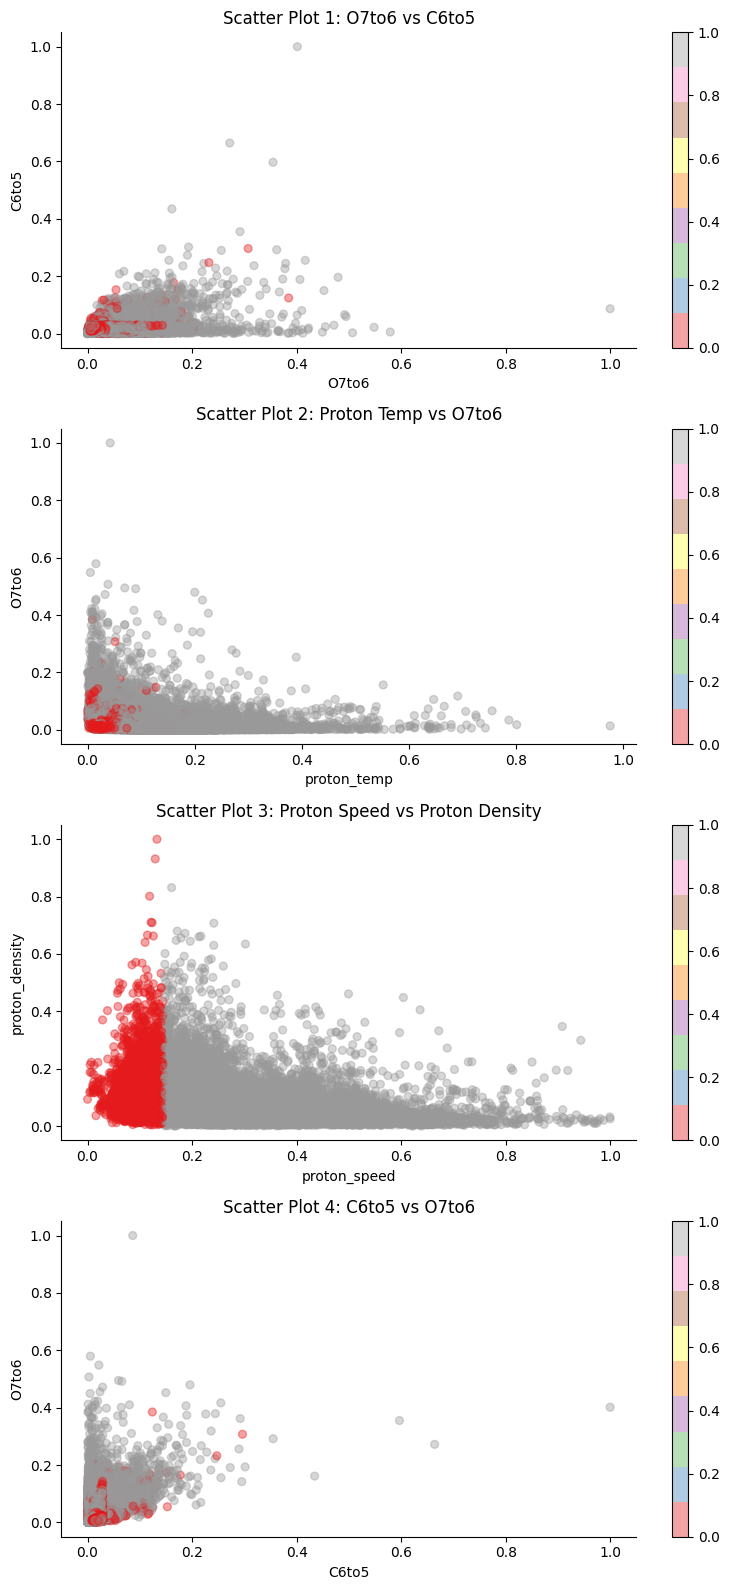

In [10]:
# Define the configurations for each plot in a list of dictionaries
plot_configs = [
    {"x": "O7to6", "y": "C6to5", "title": "Scatter Plot 1: O7to6 vs C6to5"},
    {"x": "proton_temp", "y": "O7to6", "title": "Scatter Plot 2: Proton Temp vs O7to6"},
    {
        "x": "proton_speed",
        "y": "proton_density",
        "title": "Scatter Plot 3: Proton Speed vs Proton Density",
    },
    {"x": "C6to5", "y": "O7to6", "title": "Scatter Plot 4: C6to5 vs O7to6"},
]

# Create a 4x1 grid of subplots. Adjust figsize as needed.
fig, axs = plt.subplots(
    nrows=4, ncols=1, figsize=(8, 16)
)  # Adjusted for better display

# Loop over the configurations and axes to plot each subplot
for ax, config in zip(axs, plot_configs):
    # Color code the points based on the "classification" column
    df.plot(
        kind="scatter",
        x=config["x"],
        y=config["y"],
        c=df["classification"].cat.codes,  # Use categorical codes for color coding
        cmap="Set1",
        s=32,
        alpha=0.4,
        ax=ax,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(config["title"])
    ax.set_ylabel(config["y"])  # Set y-axis label

# Adjust layout to prevent overlap and ensure labels/titles are clear
plt.tight_layout()

# Show the plot
plt.show()

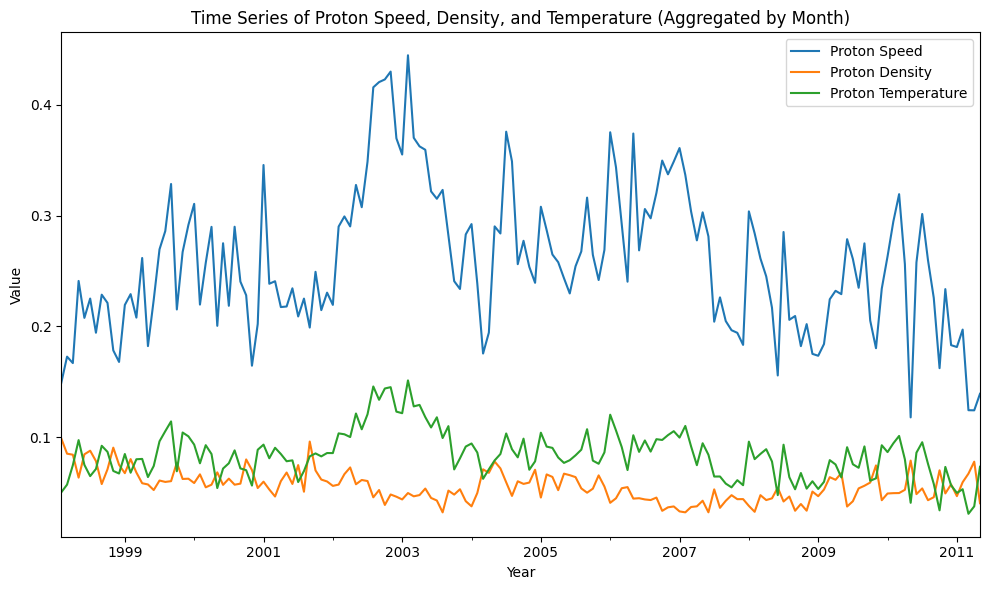

In [11]:
df["datetime"] = pd.to_datetime(df["datetime"])
df_agg = df.groupby(df["datetime"].dt.to_period("M")).mean()
df_agg.plot(y=["proton_speed", "proton_density", "proton_temp"], figsize=(10, 6))

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Time Series of Proton Speed, Density, and Temperature (Aggregated by Month)")
plt.legend(["Proton Speed", "Proton Density", "Proton Temperature"])
plt.tight_layout()
plt.show()

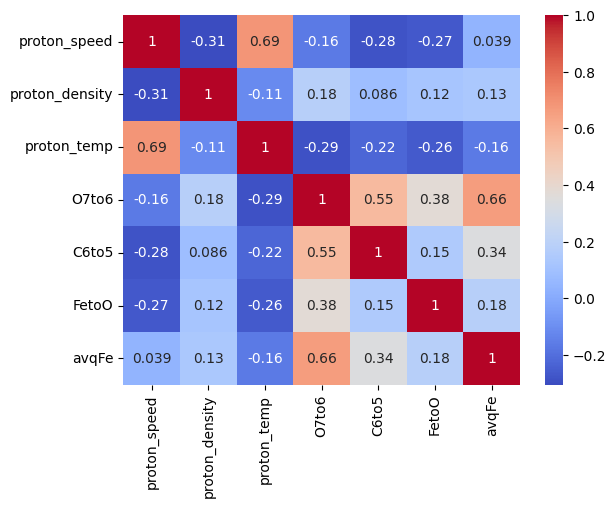

In [12]:
# Select the numeric columns from the DataFrame
numeric_columns = ['proton_speed', 'proton_density', 'proton_temp', 'O7to6', 'C6to5', 'FetoO', 'avqFe']
numeric_df = df[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm');

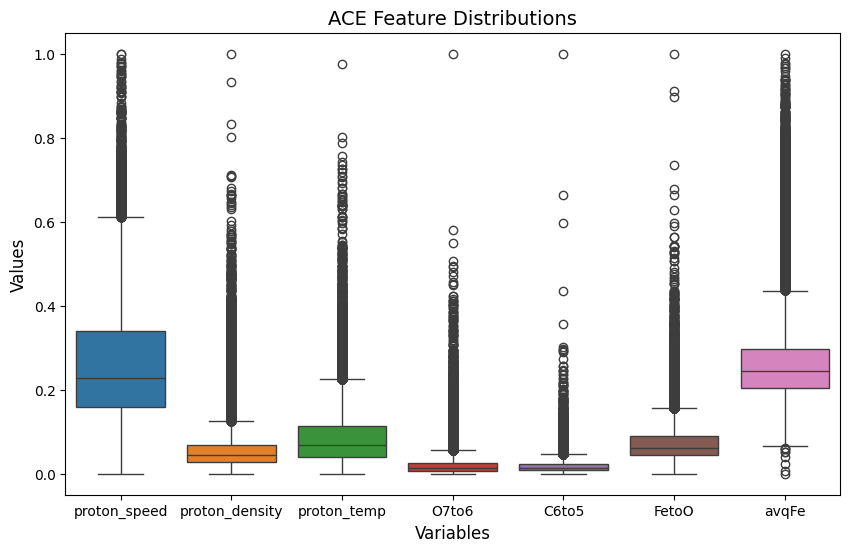

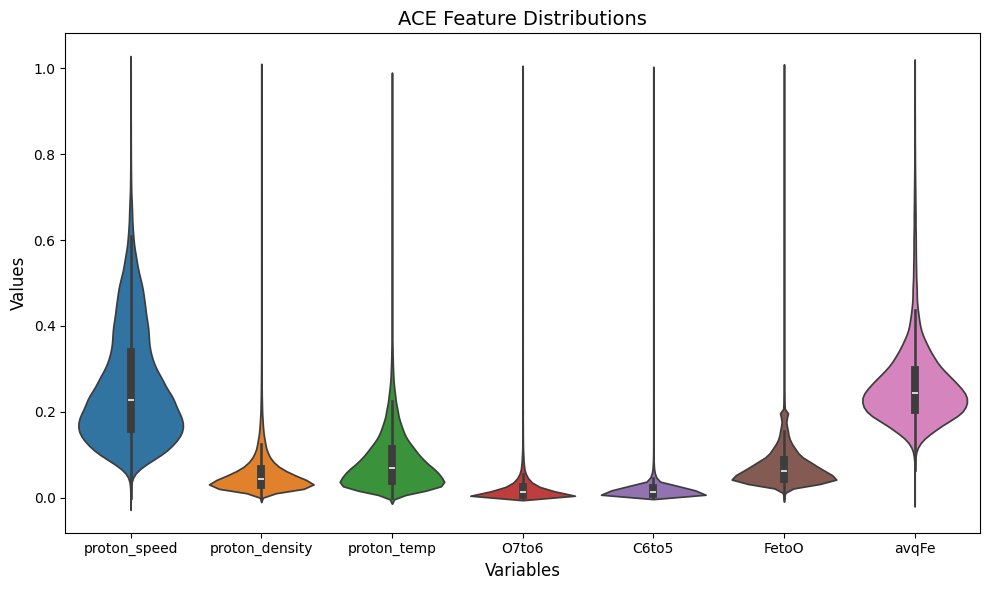

In [13]:
# Set figure size
plt.figure(figsize=(10, 6))

# Create box plots
sns.boxplot(data=X)

# Set x and y labels
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Set title
plt.title('ACE Feature Distributions', fontsize=14)

# Increase tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

# Set figure size
plt.figure(figsize=(10, 6))

# Create violin plots
sns.violinplot(data=X)

# Set x and y labels
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Set title
plt.title('ACE Feature Distributions', fontsize=14)

# Increase tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

## Dimensionality Reduction


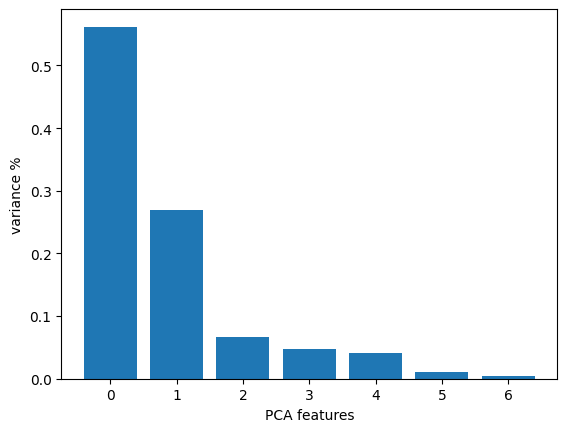

In [23]:
# Fit PCA and save components
pca = PCA().fit(X)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel("PCA features")
plt.ylabel("variance %")
plt.xticks(features)
plt.show()

In [24]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.where(cumulative_variance > 0.95)[0][0] + 1
print("Number of components to explain 95% Variance: ", num_components)

Number of components to explain 95% Variance:  5


In [25]:
# Create a PCA that will retain ideal components
pca = PCA(n_components=num_components, whiten=True)

# Conduct PCA
X_pca = pca.fit_transform(X)

# Show the new data
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (72018, 7)
transformed shape: (72018, 5)


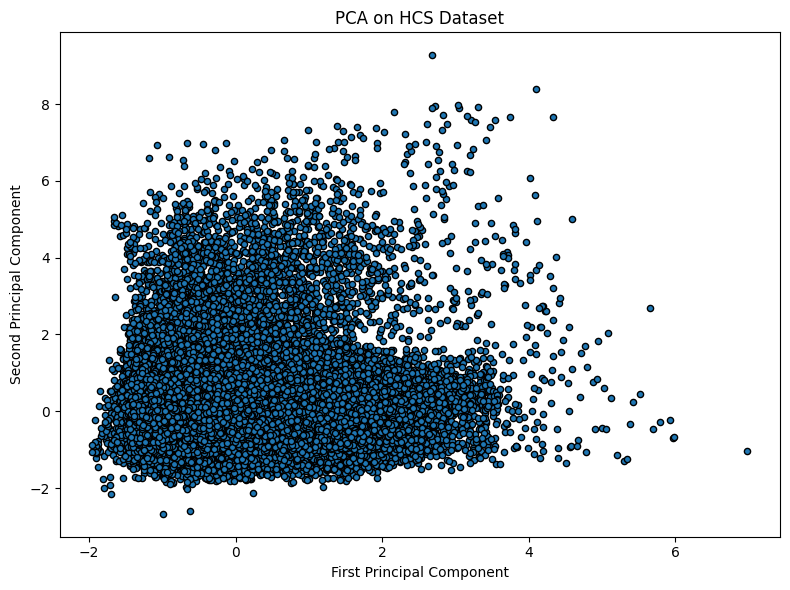

In [26]:
# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor="k", s=20)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA on HCS Dataset")
plt.tight_layout()
plt.show()

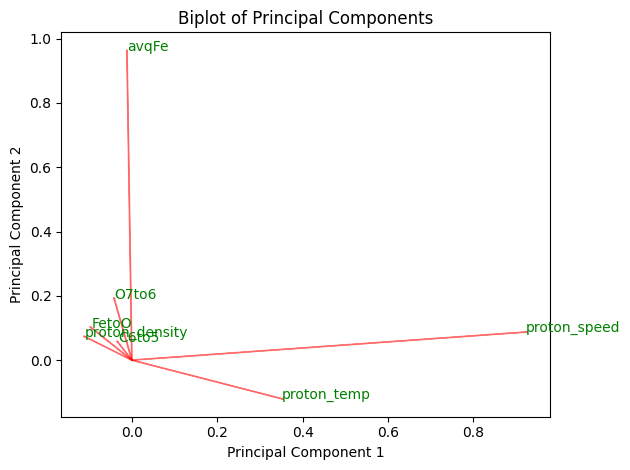

In [27]:
# Add arrows representing the variables (features) to the plot
feature_vectors = pca.components_.T
n_features = feature_vectors.shape[0]
for i in range(n_features):
    plt.arrow(0, 0, feature_vectors[i, 0], feature_vectors[i, 1], color='r', alpha=0.5)
    plt.text(feature_vectors[i, 0], feature_vectors[i, 1], numeric_columns[i], color='g')

# Set the x and y axis labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Set the title of the plot
plt.title('Biplot of Principal Components')

# Show the plot
plt.tight_layout()
plt.show()

### Dimensionality Reduction Using Kernel PCA

In [ ]:
# Fit Kernel PCA with n_components=None to compute all components
kpca = KernelPCA(n_components=None, kernel="rbf")
kpca.fit(X)

# Get eigenvalues
eigenvalues = kpca.lambdas_

# Plot eigenvalues
plt.plot(eigenvalues, "bo-")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.show()

### Dimensionality Reduction Using Autoencoders

In [28]:
# # Define the size of the encoded representation
# encoding_dim = 2  # 2-dimensional encoded representation

# # Define the input layer
# input_img = Input(shape=(X.shape[1],))

# # Define the encoded layer
# encoded = Dense(encoding_dim, activation="relu")(input_img)

# # Define the decoded layer
# decoded = Dense(X.shape[1], activation="sigmoid")(encoded)

# # Define the autoencoder model
# autoencoder = Model(input_img, decoded)

# # Define the encoder model
# encoder = Model(input_img, encoded)

# # Define the decoder model
# encoded_input = Input(shape=(encoding_dim,))
# decoder_layer = autoencoder.layers[-1]
# decoder = Model(encoded_input, decoder_layer(encoded_input))

# # Compile the autoencoder
# autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")

# # Train the autoencoder
# autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True)

# # Use the encoder to reduce the dimensionality of the data
# X_encoded = encoder.predict(X)

# print("original shape:   ", X.shape)
# print("transformed shape:", X_encoded.shape)

## Clustering

### K-Means

### Bayesian Gaussian Mixture (BGM)